In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
bank_df = pd.read_csv("Bank_Churn.csv")
dim_geo = pd.read_excel("dimensiontables.xlsx", sheet_name='Geography')
dim_gender = pd.read_excel("dimensiontables.xlsx", sheet_name='Gender')
dim_exit = pd.read_excel("dimensiontables.xlsx", sheet_name='Customer Exit')
dim_card = pd.read_excel("dimensiontables.xlsx", sheet_name='Credit card')
dim_active = pd.read_excel("dimensiontables.xlsx", sheet_name='Active customers')

# Optional: Load customer info for name join (if needed in reporting)
cust_info = pd.read_csv("CustomerInfo.csv")

In [2]:
# Merge dimension tables to add readable columns
df = (bank_df
      .merge(dim_geo, left_on="GeographyID", right_on="GeographyID", how="left")
      .merge(dim_gender, left_on="GenderID", right_on="GenderID", how="left")
      .merge(dim_exit, left_on="Exited", right_on="ExitID", how="left")
      .merge(dim_card, left_on="HasCrCard", right_on="CreditID", how="left")
      .merge(dim_active, left_on="IsActiveMember", right_on="ActiveID", how="left")
)

df.rename(columns={
    "GeographyLocation": "Geography",
    "GenderCategory": "Gender",
    "ExitCategory": "ExitedLabel",
    "Category": "CreditCardStatus",
    "ActiveCategory": "MembershipStatus"
}, inplace=True)


In [3]:
df.info()
df.describe()

missing = df.isnull().sum()
print("Missing values per column:", missing)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   RowNumber         10000 non-null  int64  
 1   CustomerId        10000 non-null  int64  
 2   CreditScore       10000 non-null  int64  
 3   GeographyID       10000 non-null  int64  
 4   GenderID          10000 non-null  int64  
 5   Age               10000 non-null  int64  
 6   Tenure            10000 non-null  int64  
 7   Balance           10000 non-null  float64
 8   NumOfProducts     10000 non-null  int64  
 9   HasCrCard         10000 non-null  int64  
 10  IsActiveMember    10000 non-null  int64  
 11  EstimatedSalary   10000 non-null  float64
 12  Exited            10000 non-null  int64  
 13  Bank DOJ          10000 non-null  object 
 14  Geography         10000 non-null  object 
 15  Gender            10000 non-null  object 
 16  ExitID            10000 non-null  int64  

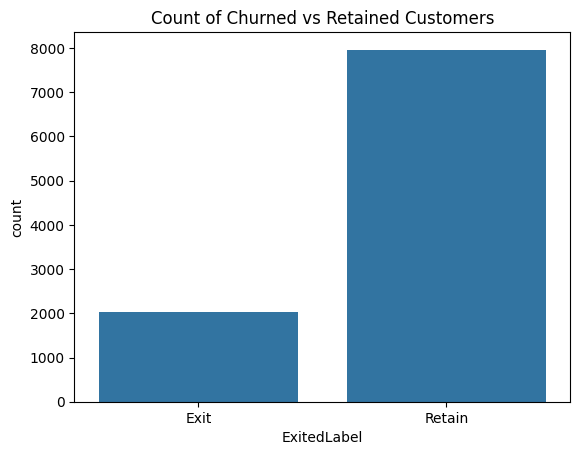

In [4]:
sns.countplot(data=df, x="ExitedLabel")
plt.title("Count of Churned vs Retained Customers")
plt.show()


In [5]:
churn_rate = df['Exited'].mean()
print(f"Churn Rate: {churn_rate:.2%}")


Churn Rate: 20.37%


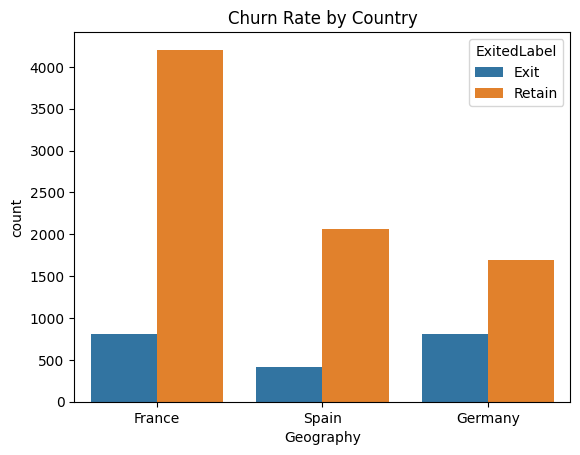

In [6]:
sns.countplot(data=df, x="Geography", hue="ExitedLabel")
plt.title("Churn Rate by Country")
plt.show()


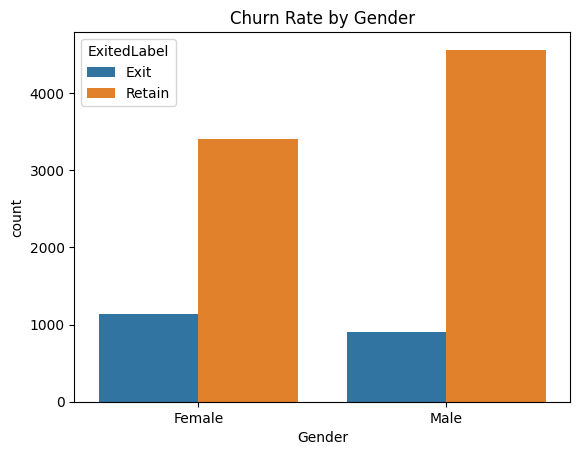

In [7]:
sns.countplot(data=df, x="Gender", hue="ExitedLabel")
plt.title("Churn Rate by Gender")
plt.show()


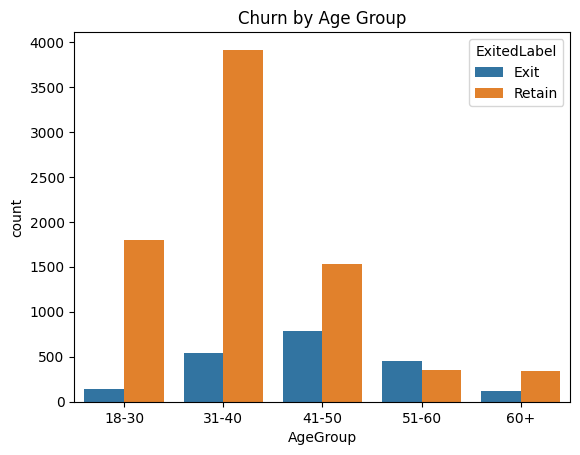

In [8]:
df['AgeGroup'] = pd.cut(df['Age'], bins=[18,30,40,50,60,80], labels=["18-30","31-40","41-50","51-60","60+"])
sns.countplot(data=df, x="AgeGroup", hue="ExitedLabel")
plt.title("Churn by Age Group")
plt.show()


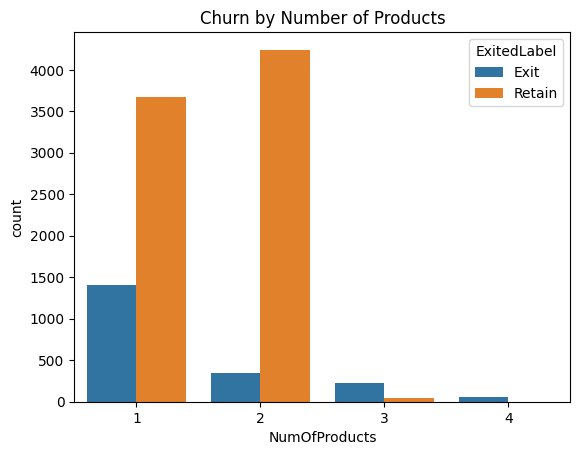

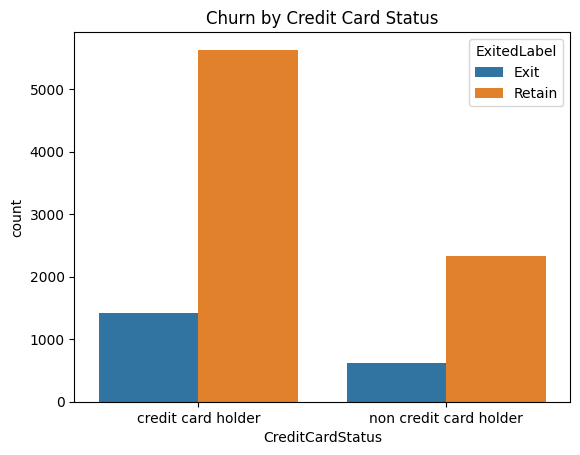

In [9]:
sns.countplot(data=df, x="NumOfProducts", hue="ExitedLabel")
plt.title("Churn by Number of Products")
plt.show()

sns.countplot(data=df, x="CreditCardStatus", hue="ExitedLabel")
plt.title("Churn by Credit Card Status")
plt.show()


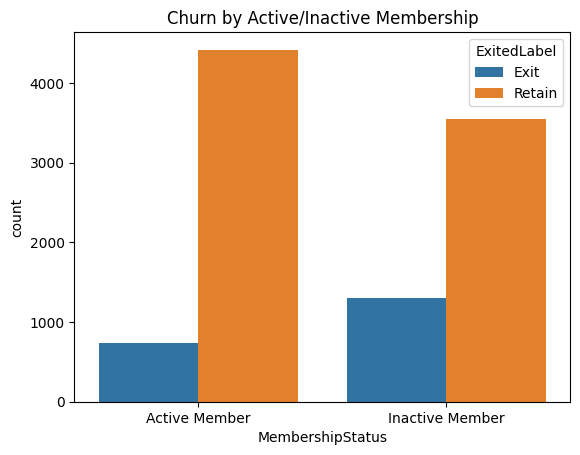

In [10]:
sns.countplot(data=df, x="MembershipStatus", hue="ExitedLabel")
plt.title("Churn by Active/Inactive Membership")
plt.show()


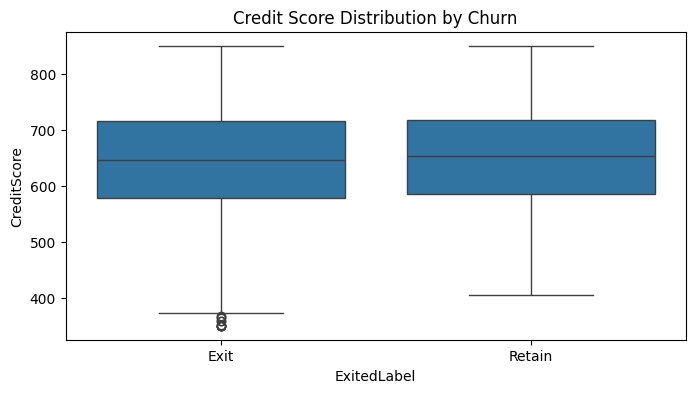

In [11]:
plt.figure(figsize=(8,4))
sns.boxplot(data=df, x="ExitedLabel", y="CreditScore")
plt.title("Credit Score Distribution by Churn")
plt.show()


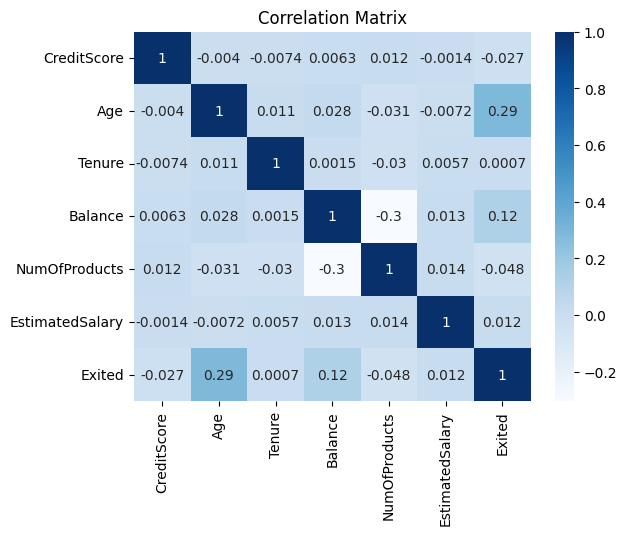

In [12]:
corr = df[["CreditScore", "Age", "Tenure", "Balance", "NumOfProducts", "EstimatedSalary", "Exited"]].corr()
sns.heatmap(corr, annot=True, cmap="Blues")
plt.title("Correlation Matrix")
plt.show()


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Basic feature engineering
features = ["CreditScore","Age","Tenure","Balance","NumOfProducts","EstimatedSalary","HasCrCard","IsActiveMember","Geography","Gender"]
X = df[features].copy()
y = df["Exited"]

# Encode categorical variables
X["Geography"] = LabelEncoder().fit_transform(X["Geography"])
X["Gender"] = LabelEncoder().fit_transform(X["Gender"])

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)


Accuracy: 0.805
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1593
           1       0.59      0.14      0.23       407

    accuracy                           0.81      2000
   macro avg       0.70      0.56      0.56      2000
weighted avg       0.77      0.81      0.75      2000



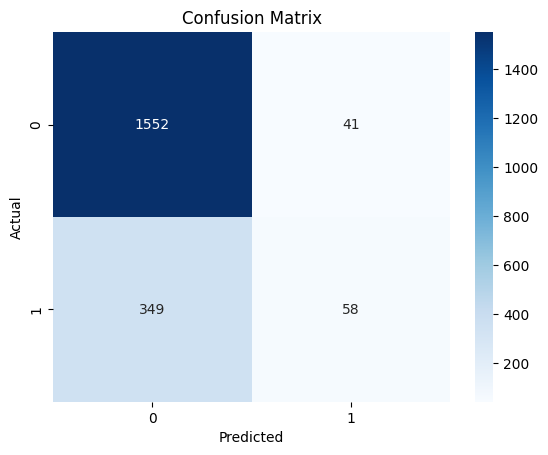

In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

# Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()
